<a href="https://colab.research.google.com/github/ThiagoMartinsThome/TFM/blob/master/RandomForestRegressor_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score,  cross_validate
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline, make_union
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, RobustScaler
from sklearn.pipeline import FeatureUnion
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import joblib
from sklearn.metrics import mean_squared_error , mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

rcParams['figure.figsize'] = 14, 8

## Load and prepare the data

#### Load the data

In [2]:
# load data
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TFM/tradebot_tfm/data_20day_chg_target.zip', parse_dates=['date'])
data.drop('long_name', axis=1, inplace=True)
data.dropna(inplace=True, axis=0)
data.sort_values(by=['ticker', 'date'], ascending=True, inplace=True)
data.set_index('date', inplace=True)

print('Null values: ', data.isnull().sum().sum())

data.head()

Null values:  0


,ticker,open,high,low,close,volume,sp_open,sp_high,sp_low,sp_close,sp_volume,sp_percent_change,percent_change,relative_change,year,month,day,day_of_year,week_of_year,quarter,f_14_period_rsi,f_14_period_stoch_k,f_20_period_cci,up_move,down_move,plus,minus,f_14_period_adx,diplus,diminus,ao,mom,macd,signal_x,f_14_period_stochastic_rsi,f_14_williams_r,bull,bear,uo,f_8_period_vama,deltawma,f_16_period_hma,tenkan,kijun,f_9_period_smm,f_9_period_ssma,f_9_period_dema,f_9_period_tema,f_18_period_trima,f_20_period_trix,f_10_period_er,f_20_period_kama,f_26_period_zlema,f_9_period_wma,f_20_period_evwma,vwap,ppo,signal_y,histo,roc,f_5_period_sma,f_5_period_ema,f_10_period_sma,f_10_period_ema,f_20_period_sma,f_20_period_ema,f_30_period_sma,f_30_period_ema,f_50_period_sma,f_50_period_ema,f_100_period_sma,f_100_period_ema,f_200_period_sma,f_200_period_ema,short_result,sector,industry
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1993-11-11,AAPL,0.921914,0.959390,0.914418,0.940652,35607600.0,28.214053,28.289897,28.119247,28.138208,88900,-0.002688,0.020325,0.023013,1993.0,11.0,11.0,315.0,45.0,4.0,60.349555,59.374851,43.972860,3.747602e-02,-1.499032e-02,0.037476,0.000000e+00,36.022545,29.416429,13.493711,0.102574,0.011243,0.039989,0.044281,0.599610,-40.625149,0.039216,-0.005756,55.330429,0.945870,0.931399,0.937907,0.937112,0.862096,0.944400,0.907955,0.942416,0.926890,0.826442,0.539938,0.050848,0.926042,0.967849,0.935405,0.862179,1.191158,4.528958,5.123036,-0.594078,5.462147,0.928659,0.931656,0.940652,0.927735,0.912732,0.898806,0.842089,0.874856,0.806337,0.862869,0.866003,0.927067,1.220093,1.040218,-10.0,Information Technology,"Technology Hardware, Storage & Peripherals"
1993-11-12,AAPL,0.944399,0.959390,0.914418,0.951894,35915600.0,28.195089,28.365738,28.176128,28.270933,108200,0.004717,0.011952,0.007235,1993.0,11.0,12.0,316.0,45.0,4.0,61.832195,68.749683,44.949612,-1.787082e-07,1.703312e-07,0.000000,1.703312e-07,36.100008,27.315254,12.529900,0.095344,0.029981,0.039336,0.043292,0.592462,-31.250317,0.034684,-0.010287,61.292067,0.941706,0.933083,0.933950,0.938361,0.871321,0.948147,0.912837,0.947884,0.936265,0.837211,0.554601,0.133332,0.926584,0.966667,0.937237,0.864885,1.190371,4.429322,4.984293,-0.554971,0.000000,0.927910,0.938402,0.943650,0.932128,0.917979,0.903862,0.851084,0.879827,0.809935,0.866361,0.863433,0.927568,1.216010,1.039203,-7.0,Information Technology,"Technology Hardware, Storage & Peripherals"
1993-11-15,AAPL,0.944400,0.981876,0.944400,0.959390,39275600.0,28.327813,28.327813,28.176124,28.251968,243300,-0.000671,0.007875,0.008546,1993.0,11.0,15.0,319.0,46.0,4.0,62.830174,69.231257,72.776436,2.248626e-02,-2.998154e-02,0.022486,0.000000e+00,36.561073,28.873022,11.634907,0.093602,0.014991,0.038973,0.042428,0.587757,-30.768743,0.052215,0.014739,55.698258,0.943250,0.939213,0.935329,0.938778,0.882131,0.948147,0.918009,0.954242,0.945976,0.848118,0.566746,0.071429,0.926963,0.968349,0.940402,0.868122,1.189586,4.362565,4.859948,-0.497383,3.225861,0.935405,0.945398,0.945149,0.937085,0.923413,0.909151,0.860328,0.884960,0.813683,0.870011,0.860565,0.928209,1.211705,1.038288,-8.0,Information Technology,"Technology Hardware, Storage & Peripherals"
1993-11-16,AAPL,0.959390,1.026847,0.951895,1.019352,75770800.0,28.308858,28.403664,28.195092,28.384703,492600,0.004698,0.062500,0.057801,1993.0,11.0,16.0,320.0,46.0,4.0,69.663353,94.444463,131.443152,4.497108e-02,-7.494871e-03,0.044971,0.000000e+00,37.634356,33.828155,10.803841,0.100932,0.037476,0.043028,0.042548,0.583771,-5.555537,0.084373,0.009421,59.569664,0.957204,0.964699,0.947400,0.942109,0.893230,0.951894,0.929270,0.980103,0.981341,0.858864,0.582450,0.161291,0.929377,0.979344,0.956059,0.877925,1.188333,4.766695,4.841297,-0.074602,10.569099,0.958640,0.970049,0.948896,0.952042,0.932782,0.919646,0.870821,0.893630,0.818330,0.875869,0.858819,0.930045,1.207848,1.038071,-12.0,Information Technology,"Technology Hardware, Storage & Peripherals"
1993-11-17,AAPL,1.019352,1.

#### Define features and targets

In [3]:
# Define features and target
X, y = data.drop('short_result', axis=1), data['short_result']
train = data[(data['year'] <= 2019) & (data['year'] >= 2000)]
test = data[data['year'] > 2019]

X_train, y_train = train.drop('short_result', axis=1), train['short_result']
X_test, y_test = test.drop('short_result', axis=1), test['short_result']

Min value:  -62.8
Max value:  85.24
(222530, 45)


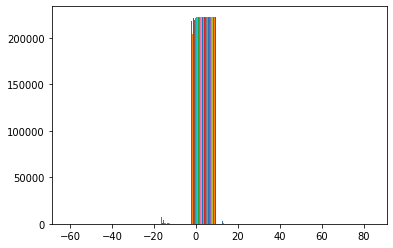

In [4]:
#Pipeline
#Column transformation
# determine categorical and numerical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

# Column preparation
transformer = [('scaler', StandardScaler(), numerical_cols),
               ('onehot', OneHotEncoder(sparse=False), categorical_cols)]
col_transform = ColumnTransformer(transformers=transformer)

pipeline_x = Pipeline(steps=[('prep', col_transform),
                             ('pca', PCA(n_components=45, random_state=1))])
pipeline_y =  Pipeline(steps=[('scaler', PowerTransformer())])

pipeline_x.fit(X)
pipeline_y.fit(y.values.reshape(-1, 1))

joblib.dump(pipeline_x, 'pipeline_x.pkl', compress=1)
joblib.dump(pipeline_y, 'pipeline_y.pkl', compress=1)

with open('pipeline_x.pkl',  'rb') as f_x:
    pipeline_x_loaded = joblib.load(f_x)

with open('pipeline_y.pkl',  'rb') as f_y:
    pipeline_y_loaded = joblib.load(f_y)

X_train_scaled, y_train_scaled = pipeline_x_loaded.transform(X_train), pipeline_y_loaded.transform(y_train.values.reshape((-1,1)))

X_train_scaled.astype('float32')
y_train_scaled.astype('float32')

print('Min value: ', round(X_train_scaled.min(),2))
print('Max value: ', round(X_train_scaled.max(),2))
print(X_train_scaled.shape)
plt.hist(X_train_scaled);

Min value:  -16.08
Max value:  15.62


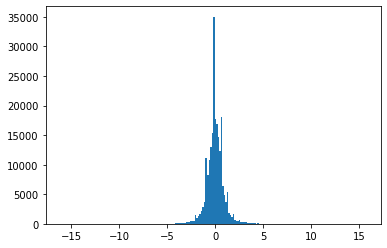

In [5]:
print('Min value: ', round(y_train_scaled.min(),2))
print('Max value: ', round(y_train_scaled.max(),2))
plt.hist(y_train_scaled, bins=200);

## Build the model

In [ ]:
# Perform grid search for hyperparameters. 
def Grid_Search_CV_RFR(X_train, y_train):
    clf = RandomForestRegressor()
    param_grid = { 
            "n_estimators"      : [100, 250],
            "max_features"      : ["auto", "sqrt", "log2"]}

    tss_splits = TimeSeriesSplit(n_splits=3).split(X_train)
    grid = GridSearchCV(clf, param_grid, cv=tss_splits, verbose=1, n_jobs=-1)

    grid.fit(X_train, y_train)

    return grid.best_score_ , grid.best_params_

best_score, best_params = Grid_Search_CV_RFR(X_train_scaled, y_train_scaled.ravel())

mf = best_params['max_features']
ne = best_params['n_estimators']

print(mf)
print(ne)

In [10]:
clf = RandomForestRegressor(n_estimators=250, max_features='sqrt')

clf.fit(X_train_scaled, y_train_scaled.ravel())

joblib.dump(clf, 'rfm_model.pkl', compress=3)

with open('rfm_model.pkl', 'rb') as f:
    loaded_model = joblib.load(f)

## Test the model

In [11]:
X_test_scaled = pipeline_x_loaded.transform(X_test)
y_test_scaled = pipeline_y_loaded.transform(y_test.values.reshape((-1,1)))

X_test_scaled.astype('float32')
y_test_scaled.astype('float32')


yhat = loaded_model.predict(X_test_scaled)
predicted = pipeline_y.inverse_transform(yhat.reshape((-1,1)))

print(round(loaded_model.score(X_test_scaled, y_test_scaled), 2))

0.01


#### Predictions

In [12]:
# Predictions table
df_predicted = pd.DataFrame()
df_predicted['short_result'] = y_test
df_predicted['predictions'] = predicted
#df_predicted = round(df_predicted,1)
print(df_predicted.head(20))

            short_result  predictions
date                                 
2020-01-02           4.0     0.910501
2020-01-03           3.0     0.849397
2020-01-06           5.0     0.381081
2020-01-07           5.0     0.777490
2020-01-08           4.0     1.782816
2020-01-09           2.0     0.826852
2020-01-10           1.0     0.848439
2020-01-13          -1.0     1.511944
2020-01-14           2.0     1.205702
2020-01-15           2.0     0.905961
2020-01-16           2.0     0.897343
2020-01-17          -1.0     2.014360
2020-01-21           1.0     1.922592
2020-01-22           0.0     1.338360
2020-01-23          -2.0     0.434467
2020-01-24          -4.0    -0.463151
2020-01-27          -3.0     0.567046
2020-01-28          -3.0     1.343218
2020-01-29          -7.0     0.237579
2020-01-30          -6.0     0.508521


#### Primero experimento con Quantiletransformer en pipeline_x

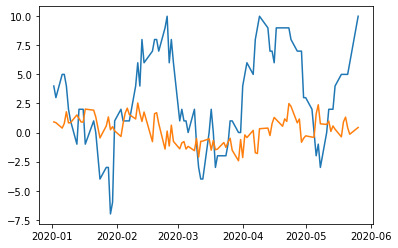

In [16]:
# Plot the predictions
plt.plot(df_predicted.iloc[:100]);

In [14]:
# Analyse the values
df_predicted.describe().T

,count,mean,std,min,25%,50%,75%,max
short_result,8182.0,0.396358,7.466665,-40.000000,-4.000000,0.000000,4.000000,38.000000
predictions,8182.0,-0.022581,1.241876,-6.360638,-0.784554,-0.007241,0.734208,8.795151


In [15]:
# Calculation of Mean Squared Error (MSE) 
mse = round(mean_squared_error(y_test, predicted), 2)
mae = round(mean_absolute_error(y_test, predicted), 2)
r2 = round(r2_score(y_test, predicted), 2) 
print('mse: ', mse)
print('mae: ', mae)
print('r2: ', r2)

mse:  55.37
mae:  5.53
r2:  0.01
